In [1]:
import sys
sys.path.append("../src/")


from kaggle_llm.core import (
    ROOT_PATH,
    count_words,
)
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import *
from sentence_transformers import SentenceTransformer
from pathlib import Path
import blingfire as bf
import argparse
import torch
import faiss
import json
import yaml


too_long_prompt_wc = 250
context_cutoff_len = 150


def split_text_into_chunks(text: str, chunk_size: int) -> List[str]:
    tokens = [i for i in text.split() if len(i) > 0]
    start = 0
    end = chunk_size
    chunks = []
    while end < len(tokens):
        chunks.append(" ".join(tokens[start: end]))
        start += chunk_size
        end += chunk_size
    return chunks


@torch.no_grad()
def get_sentence_embeddings(
        wiki_df_path: Union[str, Path],
        model: SentenceTransformer
):
    wiki_df = pd.read_csv(wiki_df_path, index_col=0)

    wc_per_page = wiki_df.groupby("page")[["word_count"]].sum().sort_values("word_count", ascending=False)
    black_list = list(wc_per_page.loc[
        (wc_per_page["word_count"] > 10000)
        | (wc_per_page.index.map(lambda x: "list of equations" in x.lower()))
    ].index)
    print(json.dumps(black_list, indent=4))

    filtered_wiki_df = wiki_df.loc[~wiki_df["page"].isin(black_list), :].copy()
    print(len(wiki_df), len(filtered_wiki_df))

    batch_size = 16
    sentences_df = []

    print("extracting sentences:")
    for _, row in tqdm(filtered_wiki_df.iterrows(), total=len(filtered_wiki_df)):
        _, sentence_offsets = bf.text_to_sentences_and_offsets(row["text"])
        for start_idx, end_idx in sentence_offsets:
            is_long_enough = (end_idx - start_idx) > 3
            is_math = "\\" in row["text"][start_idx: end_idx]  # leads to excessive tokens
            if is_long_enough and (not is_math):
                sentences_df.append({
                    "page": row["page"],
                    "i_sentence": len(sentences_df),
                    "text": row["text"][start_idx: end_idx],
                })

    sentences_df = pd.DataFrame.from_records(sentences_df)
    print(f"extracted: {len(sentences_df)} sentences")

    print(f"dropping too long sentences")
    pass_indices = sentences_df.loc[sentences_df["text"].apply(count_words) < context_cutoff_len, "text"].index
    print(f"keeping {len(pass_indices) / len(sentences_df) * 100} % at cutoff {context_cutoff_len}")
    sentences_df = sentences_df.loc[pass_indices, :].reset_index().copy()

    print("computing wiki embeddings:")
    sentence_embeddings = model.encode(
        sentences_df["text"].values,
        batch_size=batch_size,
        device="cuda",
        show_progress_bar=True,
        convert_to_tensor=True,
        normalize_embeddings=True,
    ).half()
    sentence_embeddings = sentence_embeddings.detach().cpu().numpy()

    sentence_index = faiss.IndexFlatIP(sentence_embeddings.shape[1])
    sentence_index.add(sentence_embeddings)
    print(f"{sentence_index.ntotal = }")
    return sentences_df, sentence_index, sentence_embeddings


In [2]:
wiki_path = "/home/clay/research/kaggle/kaggle_llm/data/physics_pages_list/physics_pages_formatted.csv"
sentence_model = "/home/clay/research/kaggle/kaggle_llm/data/sentence_transformer_model"
model = SentenceTransformer(sentence_model, device="cuda")
model.max_seq_length = 384
model = model.half()

In [3]:
s_df, s_idx, s_embs = get_sentence_embeddings(
    wiki_path,
    model,
)

[
    "Galactocentric distance",
    "List of equations in classical mechanics",
    "List of equations in quantum mechanics",
    "List of equations in wave theory",
    "List of equations in fluid mechanics",
    "List of equations in nuclear and particle physics",
    "List of equations in gravitation"
]
4096 4054
extracting sentences:


100%|█████████████████████████████████████████████████████████████| 4054/4054 [00:01<00:00, 3072.55it/s]


extracted: 30079 sentences
dropping too long sentences
keeping 99.95345589946474 % at cutoff 150
computing wiki embeddings:


Batches:   0%|          | 0/1880 [00:00<?, ?it/s]

sentence_index.ntotal = 30065


In [4]:
s_embs.shape

(30065, 384)

In [5]:
k = 5
niter = 200
verbose = True
kmeans = faiss.Kmeans(
    s_embs.shape[1], 
    k, 
    niter=niter, 
    verbose=verbose
)
kmeans.train(s_embs)
kmeans_index = faiss.IndexFlatIP(s_embs.shape[1])
kmeans_index.add(kmeans.centroids)

Sampling a subset of 1280 / 30065 for training
Clustering 1280 points in 384D to 5 clusters, redo 1 times, 200 iterations
  Preprocessing in 0.01 s


In [6]:
scores, neighbours = kmeans_index.search(s_embs, k)

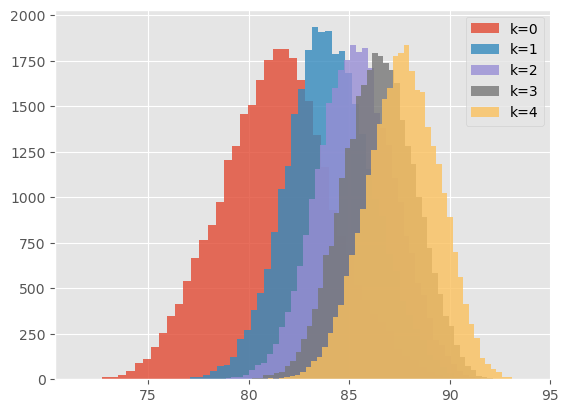

In [8]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")


plt.close()
plt.figure()
for i in range(k):
    _ = plt.hist(np.arccos(scores[:, i]) / np.pi * 180, bins=50, alpha=0.8, label=f"k={i}")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import sklearn


dummy_data, y = sklearn.datasets.make_blobs(
    n_samples=1000, 
    n_features=2
)

dummy_kmeans = faiss.Kmeans(
    dummy_data.shape[1], 
    3,
    niter=20, 
    verbose=True,
)
dummy_kmeans.train(dummy_data)

plt.scatter(dummy_data[:, 0], dummy_data[:, 1])

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns


reducer = umap.UMAP(random_state=42, metric="cosine")
reduced_embs = reducer.fit_transform(s_embs)

In [ ]:
plt.scatter(
    reduced_embs[::10, 0],
    reduced_embs[::10, 1],
)

In [ ]:
from sklearn.cluster import HDBSCAN

In [ ]:
clusterer = HDBSCAN()

In [ ]:
clusterer.fit(s_embs)